# Introduction
# Getting Ready for This Homework
# Programming Tasks

## Creating Your Own Multi-Instance Object Localization Dataset

In [3]:
from pycocotools.coco import COCO

trainAnnFile = "../coco2014/annotations_trainval/instances_train2014.json"
cocoTrain = COCO(trainAnnFile)
valAnnFile = "../coco2014/annotations_trainval/instances_val2014.json"
cocoVal = COCO(valAnnFile)

loading annotations into memory...
Done (t=9.91s)
creating index...
index created!
loading annotations into memory...
Done (t=4.49s)
creating index...
index created!


In [1]:
import os
import json
from PIL import Image

class_list = ["pizza", "bus", "cat"]

def generate_dataset(coco, inPath, outPath, annFileName):
    coco_labels_inverse = {}
    catIds = coco.getCatIds(catNms=class_list)
    categories = coco.loadCats(catIds)

    # like this because getCatIds doesn't return them in same order as passed in
    coco_labels_inverse = dict()
    for idx , in_class in enumerate(class_list):
        for c in categories:
            if c ['name'] == in_class:
                coco_labels_inverse[c['id']] = idx

    imgIds = set()
    for catId in catIds:
        imgIds |= set(coco.getImgIds(catIds=catId))
        
    imgs = coco.loadImgs(imgIds)    
    annotations = list()
    for img in imgs:
        # need catIds, filters out annotations that don't have one of the categories
        # (these images guaranteed (by above) to have one of the categories, but may have extras)
        annIds = coco.getAnnIds(imgIds=img["id"], catIds=catIds, iscrowd=False)
        anns = coco.loadAnns(annIds)
        anns = list(filter(lambda x: x['area'] > 4096, anns))
        if len(anns) == 0: continue

        pic = Image.open(os.path.join(inPath, img["file_name"]))
        newPic = pic.resize((256,256))
        filename = '{:05}.jpg'.format(len(annotations))
        
        xs = newPic.size[0] / pic.size[0]
        ys = newPic.size[1] / pic.size[1]
        
        newAnns = list()
        for ann in anns:
            bbox = ann["bbox"]
            newBbox = [int(bbox[0]*xs), int(bbox[1]*ys), 
                       int(bbox[2]*xs), int(bbox[3]*ys)]
            newAnns.append({
                "bbox": newBbox,
                "category": coco_labels_inverse[ann["category_id"]]
            })
        
        newPic.save(os.path.join(outPath, filename))   
        annotation = {
            "file_name": filename,
            "ann": newAnns
        }
        annotations.append(annotation)
        
    with open(annFileName, "w") as file:
        file.write(json.dumps(annotations, indent=4))
    print("num images in", annFileName, ":", len(annotations))

# generate_dataset(cocoTrain, "../coco2014/train/", "dataset/train/", "dataset/train_ann.json")
print("num images in dataset/train_ann.json : 6883") # 2,816 pizza, 3,025 bus, 2,894 cat
# generate_dataset(cocoVal, "../coco2014/val/", "dataset/val/", "dataset/val_ann.json")
print("num images in dataset/val_ann.json : 3491")

num images in dataset/train_ann.json : 6883
num images in dataset/val_ann.json : 3491


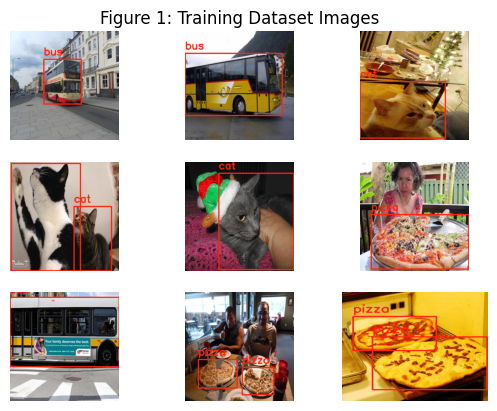

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

with open("dataset/train_ann.json", "r") as file:
    labels = json.loads(file.read())

plt.figure()
fignum = 0
counts = {i: 0 for i, _ in enumerate(class_list)}

for label in labels:
    # if len(list(filter(lambda x: counts[x["category"]] < 3))) == 0: continue
    shouldSkip = True
    for ann in label["ann"]:
        if counts[ann["category"]] < 3:
            shouldSkip = False
            counts[ann["category"]] += 1
            break
    if shouldSkip: continue
    fignum += 1
    
    pic = Image.open(os.path.join("dataset/train/", label["file_name"]))
    image = np.array(pic, dtype=np.uint8)

    for ann in label["ann"]:
        [x, y, w, h] = ann["bbox"]
        image = cv2.rectangle(image, (x,y), (x+w, y+h), (255,36,12), 2)
        image = cv2.putText(image, class_list[ann["category"]], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,36,12), 2)
    
    ax = plt.subplot(3,3,fignum)
    plt.imshow(image)
    ax.set_axis_off()
    
    if fignum == 2:
        ax.set_title("Figure 1: Training Dataset Images")
    if fignum > 9:
        break

plt.axis("tight")
plt.show()

## Building Your Deep Neural Network

In [33]:
import torch
from torch import nn

class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=True)
        # about inplace https://discuss.pytorch.org/t/when-inplace-operation-are-allowed-and-when-not/169583/2
        
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)
        
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out = out + identity
        return self.relu(out)
        

class HW6Net(nn.Module):
    """ Resnet - based encoder that consists of a few
    downsampling + several Resnet blocks as the backbone
    and two prediction heads .
    """
    def __init__(self, input_nc, classes=3, ngf=8, n_blocks=4):
        """
        Parameters :
            input_nc (int)    -- the number of channels in input images
            ngf (int)         -- the number of filters in the first conv layer
            n_blocks (int)    -- the number of ResNet blocks
        """
        assert(n_blocks >= 0)
        super().__init__()
        # The first conv layer
        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0),
                 nn.BatchNorm2d(ngf),
                 nn.ReLU(True)]        # size batchxngf,256x256
        # Add downsampling layers
        n_downsampling = 4
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf*mult, ngf*mult*2, kernel_size=3, stride=2, padding=1),
                      nn.BatchNorm2d(ngf*mult*2),
                      nn.ReLU(True)]
            # h,w go from 256->128->64->32->16
            # c go from ngf=8->16->32->64->128
        
        # Add your own ResNet blocks
        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResBlock(ngf*mult, ngf*mult)]
            
        model += [nn.Conv2d(ngf*mult, 64, kernel_size=3, stride=2, padding=1), # so cxwxh is 64,8x8
                  nn.BatchNorm2d(64),
                  nn.ReLU(True),
                  nn.Conv2d(64, (5+classes)*5, kernel_size=3, padding=1)]
        self.model = nn.Sequential(*model)
        
        self.sigmoid = nn.Sigmoid()
        
        
    def forward(self, x):
        ft = self.model(x)
        ft = ft.view(-1, 5, num_cells*num_cells, (5+len(class_list)))
        ft[:,:,:,0] = self.sigmoid(ft[:,:,:,0])
        return ft
    
model = HW6Net(3)
num_layers = len(list(model.parameters()))
print("Total number of learnable layers:", num_layers)

Total number of learnable layers: 58


## Training and Evaluating Your Trained Network

In [112]:
import torchvision.transforms as tvt
import torchvision.ops as tops
import matplotlib.transforms as mattrans

num_cells = 8

class MyRandomAffine(tvt.RandomAffine):
    def __init__(self,
        degrees,
        translate=None,
        scale=None,
        shear=None,
        interpolation=tvt.InterpolationMode.NEAREST,
        fill=0,
        center=None,
    ):
        super().__init__(degrees, translate, scale, shear, interpolation, fill, center)
    
    def get_params(self, degrees, translate, scale_ranges, shears, img_size):
        self.myParams = super().get_params(degrees, translate, scale_ranges, shears, img_size)
        return self.myParams

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, ann_file, root_dir, augment=False):
        super().__init__()
        with open(ann_file, "r") as file:
            self.labels = json.loads(file.read())
        self.root_dir = root_dir
        self.augment = augment
        
        self.affineTrans = MyRandomAffine(0, (.3, .3), (.75, 1.25))
        if augment:
            self.transform = tvt.Compose([
                tvt.ToTensor(),
                tvt.ColorJitter(brightness=.2, hue=.1)
            ])
        else:
            self.transform = tvt.ToTensor()
        
        x,y = np.meshgrid(np.arange(num_cells), np.arange(num_cells))
        self.pts = np.vstack((x.ravel(), y.ravel())).T * 256/num_cells # + 256/16
        self.create_template_anchor_boxes()
                
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        filename = self.labels[index]["file_name"]
        
        anchorIdx = list()
        anchorBoxIdx = list()
        bboxData = list()
        labels = list()
        
        pic = Image.open(os.path.join(self.root_dir,filename)).convert("RGB")
        img = self.transform(pic)
        
        # if self.augment:
        #     img = self.affineTrans(img)
        
        gt = torch.zeros(5, num_cells*num_cells, 5+len(class_list))
        
        for ann in self.labels[index]["ann"]:
            bbox = ann["bbox"]
            bbox = np.array([bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]])
            
            # if self.augment:
            #     _, trans, scale, _ = self.affineTrans.myParams
            #     # print(trans, scale)
            #     trans = mattrans.Affine2D().scale(scale).translate(*trans)
            #     out = trans.transform([bbox[0:2], bbox[2:]])
            #     bbox = out.flatten()
            
            center = np.array([bbox[0] + bbox[2], bbox[1] + bbox[3]])/2
            diff = (center - 256/num_cells/2) - self.pts
            anchor = np.argmin(np.einsum("ij,ij->i", diff, diff))
            ptstogether = np.hstack((self.pts[anchor], self.pts[anchor]))
            gtbbox = torch.unsqueeze(torch.tensor(bbox.flatten()), 0)
            anchorBox = np.argmax(tops.box_iou(self.anchor_boxes + ptstogether, gtbbox).numpy())
            
            delx = diff[anchor][0] / self.cell_size
            dely = diff[anchor][1] / self.cell_size 
            abox = self.anchor_boxes[anchorBox].numpy()
            sigw = np.log(ann["bbox"][2] / (abox[2] - abox[0]))
            sigh = np.log(ann["bbox"][3] / (abox[3] - abox[1]))
            
            anchorIdx.append(anchor)
            anchorBoxIdx.append(anchorBox)
            bboxData.append([1, delx, dely, sigw, sigh])
            labels.append(ann["category"])
            
            label = np.zeros(len(class_list))
            label[ann["category"]] = 1
            gt[anchorBox][anchor] = torch.tensor([1, delx, dely, sigw, sigh, *label])
        

        
        return img, gt, len(labels)
            
            
    def create_template_anchor_boxes(self): 
        w = h = 256/num_cells
        self.cell_size = w
        
        bboxes = list()
        bboxes.append([0,0,    w,h])
        bboxes.append([-w,0,   2*w,h])
        bboxes.append([-2*w,0, 3*w,h])
        bboxes.append([0,-h,   w, 2*h])
        bboxes.append([0,-2*h, w, 3*h])
        
        self.anchor_boxes = torch.tensor(bboxes)

# def convert_to_bboxes2(output, indexes):
#     confidences = list()
#     bboxes = list()
#     classes = list()
#     print('out indexes:', output, indexes)
    
#     for i, index in enumerate(indexes):
#         _, box, anchor = index
#         abox = valDataset.anchor_boxes[box]
        
#         ow = abox[2] - abox[0]
#         oh = abox[3] - abox[1]
#         w = ow * np.exp(output[i][3]) / 2
#         h = oh * np.exp(output[i][4]) / 2

#         c = np.array([output[i][1], output[i][2]])*valDataset.cell_size + valDataset.pts[anchor] + 256/num_cells/2
#         print('redo center', c)
        
#         bbox = np.array([c[0]-w, c[1]-h, c[0]+w, c[1]+h])
#         bbox = np.clip(bbox, 0, 255).astype(np.uint8)
#         bboxes.append(bbox)
        
#         classes.append(np.argmax(output[i][5:]))
#         confidences.append(output[i][0])
        
#     return confidences, np.array(bboxes), np.array(classes)

In [113]:
trainDataset = MyDataset("dataset/train_ann.json", "dataset/train", True)
valDataset = MyDataset("dataset/val_ann.json", "dataset/val")

trainDataloader = torch.utils.data.DataLoader(trainDataset, shuffle=True, batch_size=8, num_workers=4)
valDataloader = torch.utils.data.DataLoader(valDataset, batch_size=14, num_workers=2)

In [114]:
import torchvision.ops as tops

def train_loop(net, dataloader):
    net.train()
    losses = list()
    device = torch.device('cuda')
    net = net.to(device)
    
    objectCriterion = torch.nn.BCELoss()
    classCriterion = torch.nn.CrossEntropyLoss()
    bboxCriterion = torch.nn.MSELoss()
        
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, betas=(0.9,0.99))
    epochs = 10
    
    objLossRun = 0
    classLossRun = 0
    bboxLossRun = 0
    
    numiters = 0
    for epoch in range(epochs):
        for i, data in enumerate(dataloader):
            # print("loaded")
            inputs, gt, numObjs = data
            inputs = inputs.to(device)
            gtcuda = gt.to(device)

            optimizer.zero_grad()
            
            outputs = net(inputs)

            idx = gt[:,:,:,0]==1
            notidx = gt[:,:,:,0]!=1

            objLoss1 = objectCriterion(outputs[idx][:,0], gtcuda[idx][:,0])
            objLoss2 = objectCriterion(outputs[notidx][:,0], gtcuda[notidx][:,0])
            
            classLoss = classCriterion(outputs[idx][:, 5:], torch.argmax(gtcuda[idx][:,5:],1))
            
            bboxLoss = bboxCriterion(outputs[idx][:,1:5], gtcuda[idx][:,1:5])
            
            # loss = objLoss + classLoss + bboxLoss
            loss = 5*(objLoss1 + bboxLoss) + classLoss + .5*objLoss2
            loss.backward()
            optimizer.step()
            
            objLossRun += objLoss1.item()
            classLossRun += classLoss.item()
            bboxLossRun += bboxLoss.item()
            
            if (numiters + 1) % 100 == 0:
                losses.append([objLossRun/100, classLossRun/100, bboxLossRun/100])
                objLossRun = 0
                classLossRun = 0
                bboxLossRun = 0
                numiters = 0
            numiters += 1
        print(f"completed epoch {epoch}: Losses: {losses[-1]}")

    return np.array(losses).T

In [115]:
model = HW6Net(3)
losses = train_loop(model, trainDataloader)

completed epoch 0: Losses: [0.08446195304393768, 1.0154290521144866, 0.10442896883934737]
completed epoch 1: Losses: [0.09062366908416152, 0.7498730391263961, 0.09264964129775763]
completed epoch 2: Losses: [0.08002317071892322, 0.5772920666635036, 0.09202717762440443]
completed epoch 3: Losses: [0.07635207610204815, 0.5065372170507908, 0.08393709529191255]
completed epoch 4: Losses: [0.08767210872843861, 0.4329948379099369, 0.08067519892007112]
completed epoch 5: Losses: [0.07269238481298089, 0.41871501080691814, 0.07744632128626108]
completed epoch 6: Losses: [0.078881143219769, 0.368817791454494, 0.08024166405200958]
completed epoch 7: Losses: [0.07442601840943099, 0.32940379302948714, 0.07253978796303272]
completed epoch 8: Losses: [0.06876158406957984, 0.3375560496747494, 0.07582438945770263]
completed epoch 9: Losses: [0.07730028063990176, 0.2286753663048148, 0.07428680315613746]


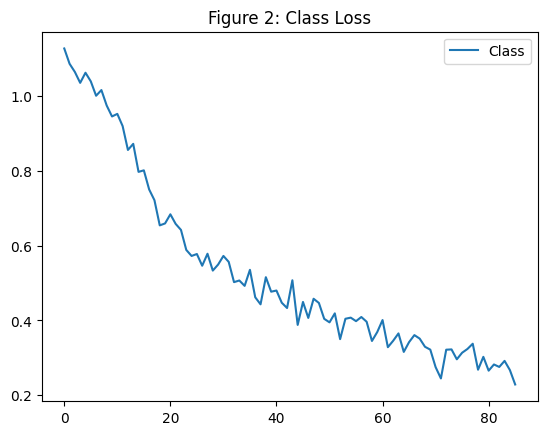

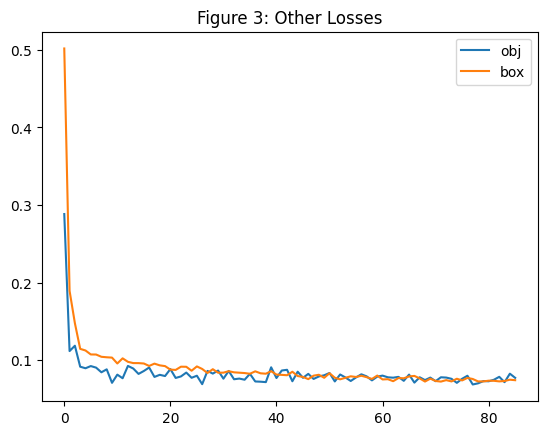

In [116]:
plt.plot(losses[1])
plt.legend(["Class"])
plt.title("Figure 2: Class Loss")
plt.show()


plt.plot(losses[[0,2]].T)
plt.legend(["obj","box"])
plt.title("Figure 3: Other Losses")
plt.show()

0.98 12
0.98 3
0.99 2
0.99 2
0.99 3
0.99 3
0.99 7
0.99 3
0.99 5


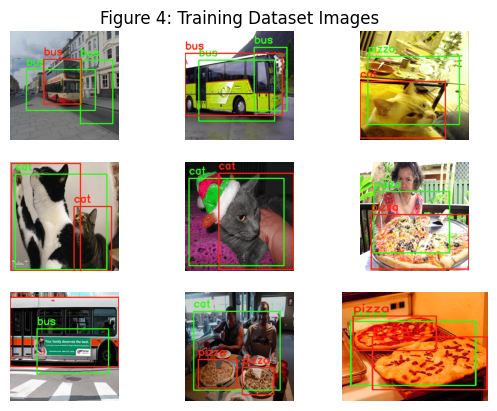

0.99 5
0.99 1
0.99 3
0.99 2
0.99 4
0.99 4
0.99 3
0.99 3
0.99 1


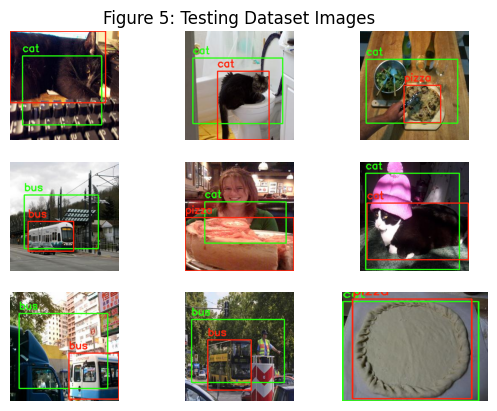

In [117]:
def convert_to_bboxes(output, indexes):
    confidences = list()
    bboxes = list()
    classes = list()
    
    for i, index in enumerate(indexes):
        _, box, anchor = index
        abox = valDataset.anchor_boxes[box]
        
        ow = abox[2] - abox[0]
        oh = abox[3] - abox[1]
        w = ow * np.exp(output[i][3]) / 2
        h = oh * np.exp(output[i][4]) / 2

        c = np.array([output[i][1], output[i][2]])*valDataset.cell_size + valDataset.pts[anchor] + 256/num_cells/2
        
        bbox = np.array([c[0]-w, c[1]-h, c[0]+w, c[1]+h])
        bbox = np.clip(bbox, 0, 255).astype(np.uint8)
        bboxes.append(bbox)
        
        classes.append(np.argmax(output[i][5:]))
        confidences.append(output[i][0])
        
    return confidences, np.array(bboxes), np.array(classes)

def eval_on_dataset(dataset, title):
    plt.figure()
    fignum = 0
    counts = {i: 0 for i, _ in enumerate(class_list)}

    with torch.no_grad():
        model.eval()
        device = torch.device('cuda')
        model.to(device)
        toPIL = tvt.ToPILImage()

        for data in dataset:
            img, gt, numObj = data
            idx = gt[:,:,0] == 1
            gt_classes = torch.argmax(gt[idx][:,5:],1).numpy()

            shouldSkip = True
            for annCls in gt_classes:
                if counts[annCls] < 3:
                    shouldSkip = False
                    counts[annCls] += 1
                    break
            if shouldSkip: continue
            fignum += 1

            img = torch.unsqueeze(img, 0)
            gt = torch.unsqueeze(gt, 0)
            img = img.to(device)
            output = model(img)

            output = output.cpu()
            threshold = .99
            idx = output[:,:,:,0] > threshold
            while torch.nonzero(idx).shape[0] == 0:
                threshold -= .01
                idx = output[:,:,:,0] > threshold
            print(threshold, torch.nonzero(idx).shape[0])

            output = output[idx]
            indexes = torch.nonzero(idx)


            scores, bboxes, classes = convert_to_bboxes(output, indexes)
            keepidx = tops.nms(torch.tensor(bboxes).type(torch.FloatTensor), torch.tensor(scores), .2)
            bboxes = bboxes[keepidx]
            classes = classes[keepidx]
            if len(keepidx) == 1:
                bboxes = [bboxes]
                classes = [classes]

            gtidx = gt[:,:,:,0] == 1
            gtindexes = torch.nonzero(gtidx)
            _, trueBboxes, truClasses = convert_to_bboxes(gt[gtidx], gtindexes)

            image = toPIL(img[0].cpu())
            image = np.array(image, dtype=np.uint8)

            for bbox, clas in zip(bboxes, classes):
                [x1, y1, x2, y2] = bbox
                image = cv2.rectangle(image, (x1,y1), (x2, y2), (36,255,12), 2)
                image = cv2.putText(image, class_list[clas], (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (36,255,12), 2)

            for bbox, clas in zip(trueBboxes, truClasses):
                [x1, y1, x2, y2] = bbox
                image = cv2.rectangle(image, (x1,y1), (x2, y2), (255,36,12), 2)
                image = cv2.putText(image, class_list[clas], (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,36,12), 2)

            ax = plt.subplot(3,3,fignum)
            plt.imshow(image)
            ax.set_axis_off()


            if fignum == 2:
                ax.set_title(title)
            if fignum >= 9:
                break
            
    plt.axis("tight")
    plt.show()

eval_on_dataset(trainDataset, "Figure 4: Training Dataset Images")
eval_on_dataset(valDataset, "Figure 5: Testing Dataset Images")

In the dataloader, I calculate the cell and anchor box to use and return a ground truth yolo_tensor. Then in the training loop I reextract the classes by taking the arg max of the class predictions.
I solve the batch problem by taking advantage of boolean array indexing.
I get all the relevant yolo_vector indexes by getting the indexes in the ground truth where the "objectness" is 1.

My performance isn't that great (at least to me).
I had similar issues as other people where the bounding box looks similar across all photos.
I believe this is the case because a lof of images have objects whose bounding box is very large and centered on the screen.
Therefore those areas are trained more often to have higher confidence. 
I think this could be remedied by using affine transforms while training.
I tried implementing this, but couldn't transform the bounding box coordinates in time for this homework submission.